# Классификации рентгеновских снимков грудной клетки с помощью нейронных сетей

Цель данной работы - применить модель глубокого обучения к задаче классификации рентгеновских снимков грудной клетки. Тренировочный и тестовый датасет взяты с платформы Kaggle. Датасет представляет собой набор картинок, относящихся к двум классам: флюрографические снимки здоровых людей и снимки людей с пневмонией. Задача классификации флюрограмм является важной медицинской задачей и поможет медицинским работникам в постановке диагноза.

In [ ]:
from google.colab import files

In [ ]:
# загрузка файла API токена Kaggle
files.upload()

In [ ]:
! chmod 600 /content/kaggle.json

In [ ]:
# загрузка датасета из Kaggle

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q -o chest-xray-pneumonia.zip

100% 2.29G/2.29G [00:25<00:00, 129MB/s]
100% 2.29G/2.29G [00:25<00:00, 95.4MB/s]


In [ ]:
import cv2
from matplotlib import pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn
from torch.nn import functional as F

1. Предобработка датасета


Посмотрим на состав наших данных. Датасет включает три набора: тренировочный датасет (train), тестовый (test) и датасет для предсказания диагноза. Посмотрим на снимки из первых двух наборов:

Text(0.5, 1.0, 'Pneumonia (760, 1152, 3)')

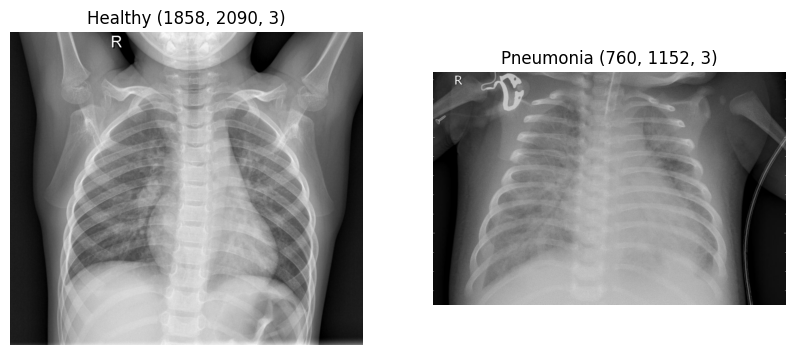

In [ ]:
data_dir = "./chest_xray/chest_xray/"


#Посмотрим на снимки здоровых и больных пневмонией пациентов
fig = plt.figure(figsize=(10, 7))

rows = 1
columns = 2

Image1 = cv2.imread(f'{data_dir}/train/NORMAL/IM-0115-0001.jpeg')
Image2 = cv2.imread(f'{data_dir}/train/PNEUMONIA/person1000_bacteria_2931.jpeg')

fig.add_subplot(rows, columns, 1)

plt.imshow(Image1)
plt.axis('off')
plt.title(f"Healthy {Image1.shape}")

fig.add_subplot(rows, columns, 2)

plt.imshow(Image2)
plt.axis('off')
plt.title(f"Pneumonia {Image2.shape}")


Text(0.5, 1.0, 'Pneumonia (616, 1056, 3)')

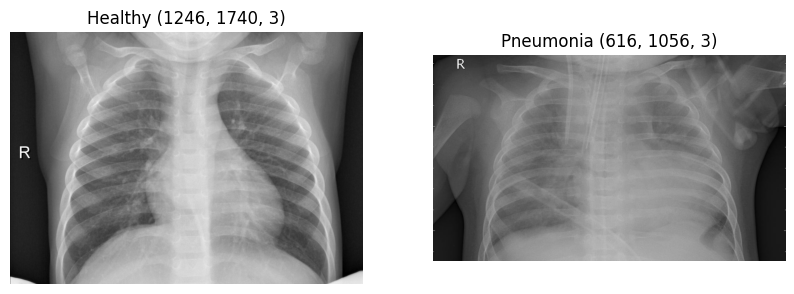

In [ ]:
fig = plt.figure(figsize=(10, 7))

rows = 1
columns = 2

Image1 = cv2.imread(f'{data_dir}/test/NORMAL/IM-0077-0001.jpeg')
Image2 = cv2.imread(f'{data_dir}/test/PNEUMONIA/person135_bacteria_646.jpeg')

fig.add_subplot(rows, columns, 1)


plt.imshow(Image1)
plt.axis('off')
plt.title(f"Healthy {Image1.shape}")


fig.add_subplot(rows, columns, 2)

plt.imshow(Image2)
plt.axis('off')
plt.title(f"Pneumonia {Image2.shape}")

Все картинки в датасете разного размера и разрешения. Чтобы обучить модель, нужно привести их к одному размеру и преобразовать в тензор.

In [ ]:
data_transforms = transforms.Compose([
    transforms.Grayscale(), # преобразуем в черно-белый формат (одноканальный)
    transforms.Resize(size=(64, 64)),
    transforms.CenterCrop(size=(64,64)),
    transforms.ToTensor(),
])


# загрузка датасетов в объекты dataset
train_dataset = datasets.ImageFolder(data_dir+"train/", transform=data_transforms)
test_dataset = datasets.ImageFolder(data_dir+"test/", transform=data_transforms)

Посмотрим на представленность двух классов в датасетах

In [ ]:
import numpy as np

train_class_counts = np.arange(2)
for image, target in train_dataset:
  train_class_counts[target] += 1

test_class_counts = np.arange(2)
for image, target in test_dataset:
  test_class_counts[target] += 1


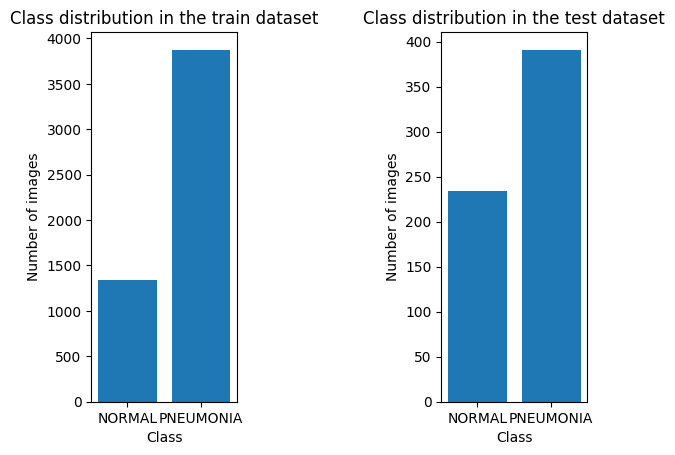

In [ ]:
plt.subplot(1,3,1)
plt.bar(train_dataset.classes, train_class_counts)
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.title(f"Class distribution in the train dataset")

plt.subplot(1,3,3)
plt.bar(test_dataset.classes, test_class_counts)
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.title(f"Class distribution in the test dataset")

plt.show()

Данные в тренировочном датасете сильно несбалансированы. Флюрограмм людей с пневмонией гораздо больше, чем здоровых. Это может повлиять на процесс обучения, например, модель лучше предсказывать класс картинок с пневмонией, чем здоровых.


Применим на тренировочном наборе алгоритм снижения размерности UMAP, чтобы посмотреть на различия между двумя классами картинок.


In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
# создадим numpy массив из всех тензоров датасета
train_dataset_array = next(iter(train_loader))[0].numpy()

In [ ]:
# значения классов
targets = next(iter(train_loader))[1].numpy()

In [ ]:
train_dataset_array.shape

(5216, 1, 64, 64)

In [ ]:
train_array_2d = train_dataset_array.reshape(5216,4096)

In [ ]:
train_array_2d.shape

(5216, 4096)

In [ ]:
!pip install umap-learn
import umap.umap_ as umap
umap_2d = umap.UMAP(random_state=0)
umap_2d.fit(train_array_2d)


In [ ]:
projections = umap_2d.transform(train_array_2d)

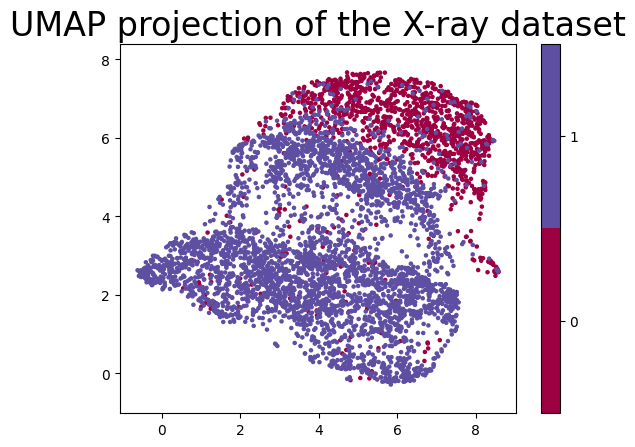

In [ ]:
plt.scatter(projections[:, 0], projections[:, 1], c=targets, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('UMAP projection of the X-ray dataset', fontsize=24);

Картинки разных классов достаточно хорошо делятся на кластеры.

То, что наш тренировочный датасет несбалансирован по классам, может помешать при обучении модели. Попробуем выровнять вероятности появления картинок разных классов в батче при помощи WeightedRandomSampler. Он присвоет каждой картинке вес, который будет больше для представителей класса NORMAL.

In [ ]:
from torch.utils.data import WeightedRandomSampler

targets = [label for im, label in train_dataset]
class_weights = 1.0 / train_class_counts
weights = [class_weights[label] for label in targets]
sampler = WeightedRandomSampler(weights, len(weights))


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 64, sampler=sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

2. Классификация снимков методами глубокого обучения


2.1. Классификация при помощи полносвязной нейронной сети

Реализуем простую архитектуру полносвязной нейронной сети для классификации.

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Flatten(), #уплощение тензора 64*64 в вектор
    torch.nn.Linear(1 * 64 * 64, 512), #скрытый слой, 512 нейронов
    torch.nn.ReLU(), #активация ReLU
    torch.nn.Linear(512, 2) # выходной слой, 2 выхода
)

# параметры модели (функция потерь и оптимизатор)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_loader, "test": test_loader}
max_epochs = 5

In [ ]:
# реализуем цикл обучения модели на тренировочном датасете и валидации на тестовом:
def train(model, loaders, criterion, optimizer, max_epochs):
  accuracy = {"train": [], "test": []}
  for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
  return accuracy["test"]

In [ ]:
FC_acc = train(model, loaders, criterion, optimizer, max_epochs)

Epoch: 1
Loader: train. Accuracy: 0.8366564417177914
Loader: test. Accuracy: 0.780448717948718
Epoch: 2
Loader: train. Accuracy: 0.9137269938650306
Loader: test. Accuracy: 0.8173076923076923
Epoch: 3
Loader: train. Accuracy: 0.9382668711656442
Loader: test. Accuracy: 0.7708333333333334
Epoch: 4
Loader: train. Accuracy: 0.9392254601226994
Loader: test. Accuracy: 0.7852564102564102
Epoch: 5
Loader: train. Accuracy: 0.9265720858895705
Loader: test. Accuracy: 0.8365384615384616


Максимальная точность на тестовом датасете составила 83%.

2.2. Классификация при помощи сверточной нейронной сети

Сверточные нейросети больше подходят для классификации картинок, так как сверточные слои обучаются выявлять конкретные паттерны, за счет чего точность классификации повышается. Реализуем архитектуру сверточной нейросети типа LeNet, но с тремя сверточными слоями с фильтрами 3*3.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3, padding = 1) # на выходе 6 карт активации 64*64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # пулинг 2*2, на выходе 6 карт активации 32*32
        self.conv2 = nn.Conv2d(6, 16, 3, padding = 1) # на выходе 16 карт активации 32*32
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # пулинг 2*2, на выходе 16 карт активации 16*16
        self.conv3 = nn.Conv2d(16, 64, 3, padding = 1) # на выходе 64 карты активации 16*16
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # пулинг 2*2, на выходе 64 карты активации 8*8
        self.fc1 = nn.Linear(8 * 8 * 64, 512)
        self.fc2 = nn.Linear(512, 120)
        self.fc3 = nn.Linear(120, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size()[0], -1)
        # Полностью связанный слой
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
max_epochs = 5
loaders = {"train": train_loader, "test": test_loader}

CNN_acc = train(model, loaders, criterion, optimizer, max_epochs)

Epoch: 1
Loader: train. Accuracy: 0.8422162576687117
Loader: test. Accuracy: 0.7884615384615384
Epoch: 2
Loader: train. Accuracy: 0.9499616564417178
Loader: test. Accuracy: 0.8637820512820513
Epoch: 3
Loader: train. Accuracy: 0.9626150306748467
Loader: test. Accuracy: 0.8205128205128205
Epoch: 4
Loader: train. Accuracy: 0.9658742331288344
Loader: test. Accuracy: 0.7996794871794872
Epoch: 5
Loader: train. Accuracy: 0.9720092024539877
Loader: test. Accuracy: 0.7596153846153846


Как мы видим, после второй эпохи модель начала переобучаться (точность на тренировочном наборе возрастает, а на тестовом - падает). Скорее всего, это связано с небольшим размером тренировочного датасета. В этом случае количество эпох обучения сильно ограничивается.

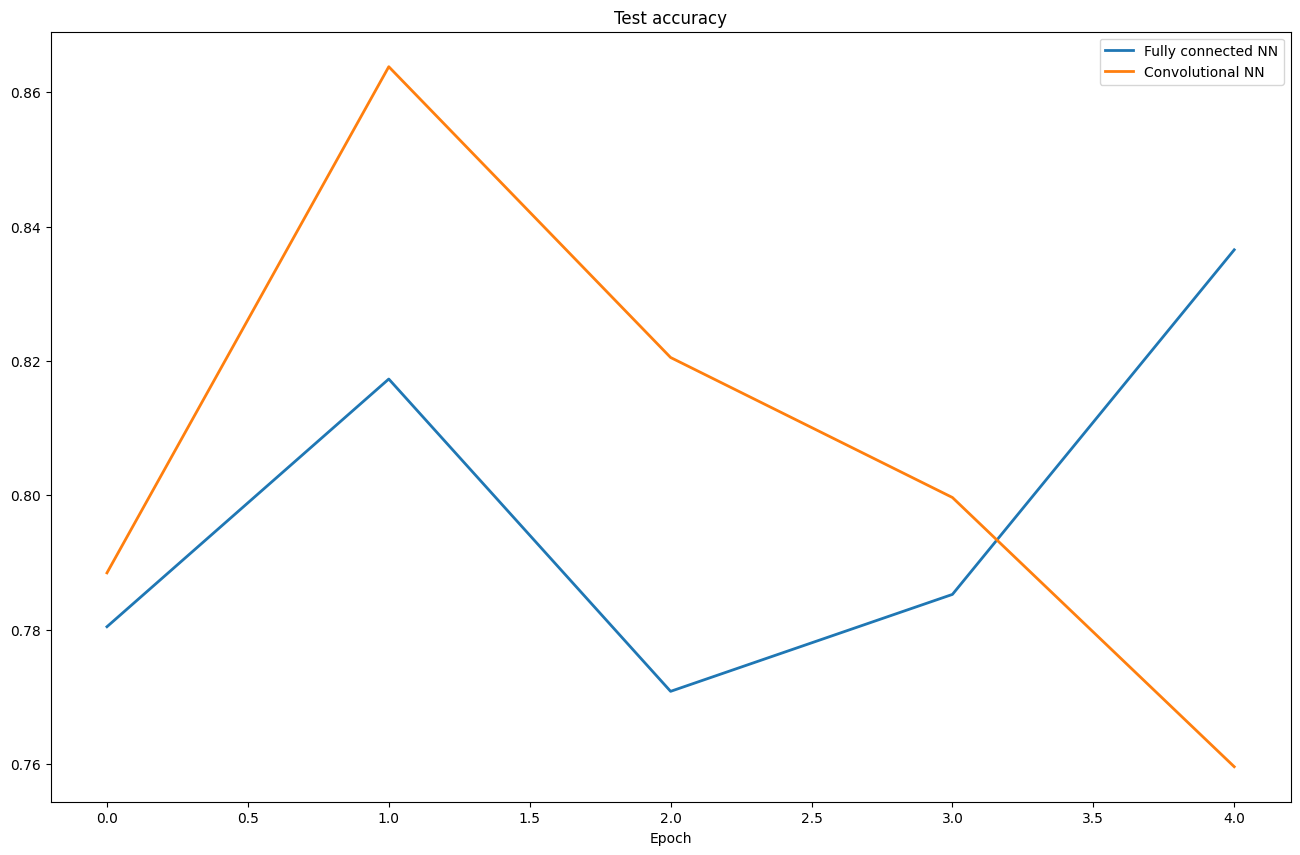

In [ ]:
# сравним точность по эпохам на тестовом датасете для полносвязной и сверточной нейросетей

plt.figure(figsize=(16, 10))
plt.title("Test accuracy")
plt.plot(range(max_epochs), FC_acc, label="Fully connected NN", linewidth=2)
plt.plot(range(max_epochs), CNN_acc, label="Convolutional NN", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

В результате, максимальная точность на тестовом датасете для полносвязной нейронной сети составила 83%, для сверточной нейронной сети типа LeNet - 86%.
Для повышения точности необходимо увеличить размер датасета (добавить новые снимки либо использовать аугментацию данных) и использовать более глубокие архитектуры нейросетей, например ResNet.